In [136]:
import findspark
    
findspark.init()

In [137]:
from enum import Enum
import pathlib

from pyspark.sql import (
                        DataFrame,
                        functions as sf,
                        SparkSession,
)


In [138]:
OutputMode = Enum("OutputMode", "results_only stats verbose")
ReadMode = Enum("ReadMode", "gzip_only parquet_only gzip_to_parquet")

"""
Config constants, changing these
will change the flow, runtime, and
output of the notebook.
Details are as follows:

DATA_FOLDER:
    data - Holds the provided data set
OUTPUT_MODE:
    results_only - Useful for comparing best-case runtimes.
    stats - Show data quality check outputs in addition to results.
    verbose - Show everything included in stats, plus intermediate
              table outputs and graphs. Slow, but informative.
READ_MODE: 
    gzip_only - Use only the original gzip data.
               Slowest performance.
    parquet_only - Use only parquet data, if it already exists.
                   Fastest performance.
    gzip_to_parquet - First convert gzip to parquet, then use parquet data.
                     Run this once before running parquet_only.
                     Conversion takes time, but still faster than gzip_only.
"""
DATA_FOLDER = "data"
DATA_FILE = "Loan_status_2007-2020Q3.gzip"
OUTPUT_MODE = OutputMode.results_only
READ_MODE = ReadMode.parquet_only

In [139]:
spark = SparkSession.builder.master("local").getOrCreate()

In [140]:
def gzip_to_parquet(path: str) -> None:
    """
    Export a gzip file as a parquet file
    with an inferred schema.

    :param path: File path to the gzip file
    """

    filename, extension = path.split("/")[-1].split(".")

    if not extension.casefold() == "gzip":
        raise TypeError(f"""
            Only gzip files are supported for parquet conversion, 
            but you tried to convert an unsupported file: {filename=}
            """
        )

    df = (
        spark
        .read
        .format("csv")
        .option("compression", "gzip")
        .option("header", True)
        .option("delimiter", ",")
        .load(f"{DATA_FOLDER}/{DATA_FILE}")
    )
            
    parquet_path = path.split(".")[0]+".parquet"

    df.write.mode("overwrite").parquet(parquet_path)

In [141]:
def read_file(path: str) -> DataFrame:
    """
    Read file and convert to a Spark DataFrame.
    Supported file extensions are gzip & parquet.

    :param path: File path of the file to process
    """

    filename, extension = path.split("/")[-1].split(".")

    if extension == "gzip":
        df = (
            spark
            .read
            .format("csv")
            .option("compression", "gzip")
            .option("header", True)
            .option("delimiter", ",")
            .load(f"{DATA_FOLDER}/{DATA_FILE}")
        )

    elif extension == "parquet":
         df = (
            spark.read
            .parquet(path)
         )
    else:
        raise ValueError(f"""
            Only gzip and parquet files are supported, but but you tried to
            read an unsupported file: {filename=}

            If you want to attempt to read an unsupported file, 
            call spark.read() directly.
            """
        )

    return df

In [142]:
# Make any pathing changes in constants above, not here
data_folder = pathlib.Path(DATA_FOLDER)

# spark.read requires path to be a str
if READ_MODE == ReadMode.gzip_only or READ_MODE == ReadMode.gzip_to_parquet:
    raw = str(pathlib.Path(DATA_FILE))

if READ_MODE == ReadMode.gzip_to_parquet:
        gzip_to_parquet(raw)

if READ_MODE == ReadMode.parquet_only or READ_MODE == ReadMode.gzip_to_parquet:
    raw = str(pathlib.Path(DATA_FILE.split(".")[0] + ".parquet"))

df_raw = read_file(raw)

# Auto-increment column didn't have a name, presumably because id was already taken. Give it a meaningful name.
df_raw = df_raw.withColumnRenamed("_c0", "entry_id")

23/06/16 05:38:40 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , id, loan_amnt, funded_amnt, funded_amnt_inv, term, int_rate, installment, grade, sub_grade, emp_title, emp_length, home_ownership, annual_inc, verification_status, issue_d, loan_status, pymnt_plan, url, purpose, title, zip_code, addr_state, dti, delinq_2yrs, earliest_cr_line, fico_range_low, fico_range_high, inq_last_6mths, mths_since_last_delinq, mths_since_last_record, open_acc, pub_rec, revol_bal, revol_util, total_acc, initial_list_status, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, next_pymnt_d, last_credit_pull_d, last_fico_range_high, last_fico_range_low, collections_12_mths_ex_med, mths_since_last_major_derog, policy_code, application_type, annual_inc_joint, dti_joint, verification_status_joint, acc_now_delinq, tot_coll_amt, tot_cur_bal, open_acc_6m, open

In [143]:
# Data quality checks

def check_dupes(df: DataFrame) -> None:
    """
    Check dataframe for duplicate rows.

    :param df: The dataframe to check
    """
    
    return (
        df.groupBy(df.columns)
        .count()
        .where(sf.col("count") > 1)
        .select(sf.coalesce(sf.sum("count"), sf.lit(0)))
        .withColumnRenamed("coalesce(sum(count), 0)", f"Duplicate Count")
        .show()
    )

def check_nulls(df: DataFrame) -> None:
    """
    Check dataframe for null values in any row.

    :param df: The dataframe to check
    """

    print("Null Counts")
    return df.select([sf.count(sf.when(sf.col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

def run_single_df_checks(df: DataFrame) -> None:
    """
    Run duplicate and null checks for a single dataframe,
    as well as displaying summary statistics.

    :param df: The dataframe to check
    """

    check_dupes(df)
    check_nulls(df)

    # Checking the schema/data + using the included data dictionary will give us a better idea of where to start
    df.describe().show()

def run_all_checks() -> None:
    """
    Run duplicate and null checks for all dataframes,
    as well as displaying summary statistics for each.
    """

    print("-----DF_RAW-----")
    run_single_df_checks(df_raw)

# Luckily the fields we're going to depend on seem mostly ok,
# and we're just doing some quick manual analysis. If we needed to use
# fields with a lot of dupes or nulls and/or we were trying to train
# a machine learning model, we'd need to think carefully about how
# we strategically dropped/imputed these values.
if OUTPUT_MODE != OutputMode.results_only:
    run_all_checks()

-----DF_RAW-----


+---------------+
|Duplicate Count|
+---------------+
|              0|
+---------------+

Null Counts


+--------+---+---------+-----------+---------------+----+--------+-----------+-----+---------+---------+----------+--------------+----------+-------------------+-------+-----------+----------+---+-------+-----+--------+----------+----+-----------+----------------+--------------+---------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------+-------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----

23/06/16 06:02:24 WARN DAGScheduler: Broadcasting large task binary with size 1333.8 KiB


+-------+-----------------+--------------------+-----------------+------------------+-----------------+----------+--------+------------------+-------+---------+--------------------+----------+--------------+------------------+-------------------+---------------+-----------+-----------+--------------------+-------+--------------------+--------------------+----------+------------------+-------------------+----------------+-----------------+-----------------+------------------+----------------------+----------------------+-----------------+-------------------+------------------+------------------+------------------+-------------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------------+-----------------+------------------+-----------------+------------------+--------------------+-------------------+--------------------------+---------------------------+-----------+-----

In [144]:
# There is only 1 entry with a non-numeric income, so we can safely drop
non_numeric = df_raw.filter(df_raw.annual_inc.rlike("^[a-zA-Z]*$"))
dropped = df_raw.join(non_numeric, on=["entry_id"], how="left_anti")

def filter_df(df: DataFrame) -> DataFrame:
    """
    Filter our dataframe to narrow our search to only
    debtors that are likely to maximize our ROI
    on outreach efforts.

    :param df: The dataframe to filter
    """

    # Late borrowers
    filtered = df.filter(sf.col("loan_status").ilike("%late%"))

    # > $10,000 outstanding
    filtered = filtered.filter(sf.col("out_prncp") > 10_000)

    # Acceptable loan grades (A, B, C)
    filtered = filtered.filter(sf.col("grade").rlike("[ABC]"))

    # Is not on a hardship plan
    filtered = filtered.filter(sf.col("hardship_flag") == "N")

    # Has not yet agreed to work with a debt settlement company
    filtered = filtered.filter(sf.col("debt_settlement_flag") == "N")

    return filtered

filtered = filter_df(dropped)

if OUTPUT_MODE == OutputMode.verbose:
    filtered.show()


+--------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+--------+------------------+----------+--------------------+------------------+--------------------+--------+----------+-----+-----------+----------------+--------------+---------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------+-------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+------

In [147]:
def income_bucket(income: str) -> int:
    """
    Bucket annual income to more easily
    visualize income distribution. Note that
    income is stored as a string in the dataframe,
    so we've chosen to first cast to a float here.
    Non-numeric values have already been dropped.

    :param income: Annual income for a single debtor 

    :returns: The bucketed income for a single debtor
    """

    income = float(income)

    # High income
    if income > 200_000:
        return 200_000
    elif income > 150_000:
        return 150_000
    
    # Mid income
    elif income > 100_000:
        return 100_000
    elif income > 75_000:
        return 75_000
    elif income > 50_000:
        return 50_000
    
    # Low income
    elif income > 25_000:
        return 25_000
    elif income > 1:
        return 1
    
    else:
        # No income
        return 0
    



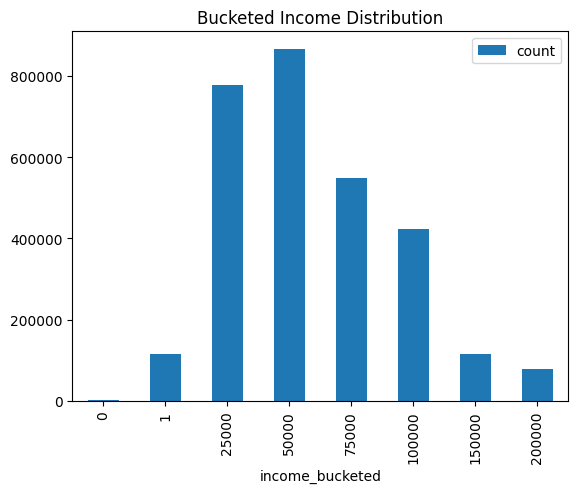

In [149]:
# This import helps us do natural sorting on the x-axis of our bar graphs
# so we get the ordering we expect, i.e. 2,000 comes before 10,000
from natsort import natsort_keygen

def bucketed_income_distribution(df: DataFrame):
    """
    Display a bar graph representing the total amount
    of debtors in each income bucket.

    :param df: The dataframe to pull data from
    """

    # Drop None/NA values and apply our bucketing function to the dataframe to create a new column
    bucketed = df.dropna(subset="annual_inc")
    bucketed = bucketed.withColumn('income_bucketed', sf.udf(income_bucket)(sf.col('annual_inc'))).groupBy("income_bucketed").count()

    bucketed_pd = bucketed.toPandas()
    bucketed_pd.sort_values(by="income_bucketed", key=natsort_keygen(), inplace=True)
    
    return bucketed_pd.plot.bar(x="income_bucketed", y="count", title="Bucketed Income Distribution")

# Let's see how income distributions of all of our debtors compare to the filtered set
if OUTPUT_MODE == OutputMode.verbose:
    bucketed_income_distribution(dropped)


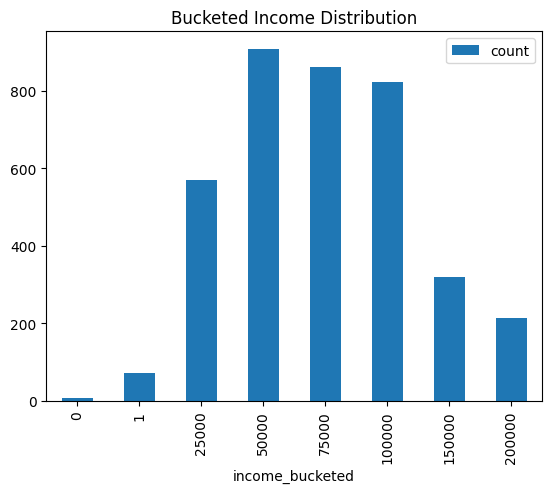

In [150]:
# Interesting to see that the filtered is more evenly distributed
# and contains more debtors with higher incomes. This could be
# bias introduced by filtering for only high-grade loans.
if OUTPUT_MODE == OutputMode.verbose:
    bucketed_income_distribution(filtered)


In [151]:
# Let's prioritize reaching out to the 50 debtors with the highest incomes and the most outstanding debt
final = filtered.filter(sf.col("annual_inc") > 200_000).orderBy("out_prncp").limit(50)
final.show()


+--------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+--------+------------------+----------+--------------------+------------------+--------------------+--------+----------+-----+-----------+----------------+--------------+---------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------+-------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+------